In [6]:
from get_era5_data_for_station import CreateMatchingEra5FileForStationData
from time_and_date_context import TimeAndDateContext
from create_training_sets import TrainingsFilePair


Process .dat files to create .nc files for the station

In [7]:
station_name = "Marshall"
test_year = 2021

import os
# if in station_data_as_nc folder there is no file with the name of the station, create one
station_as_nc_path = f"{os.getcwd()}/station_data_as_nc/{station_name.lower()}.nc"
needs_to_convert_to_netcdf = not os.path.isfile(station_as_nc_path)
print(f"needs_to_convert_to_netcdf: {needs_to_convert_to_netcdf}")

needs_to_convert_to_netcdf: False


In [8]:
if needs_to_convert_to_netcdf:
    
    from dat_to_nc import DatToNcConverter
    converter = DatToNcConverter(station_name.lower())
    converter.execute()
    import xarray as xr
    ds = xr.open_dataset(converter.target_directory + "/" + converter.name.lower() + ".nc")


/home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/marshall.nc has  59151  values


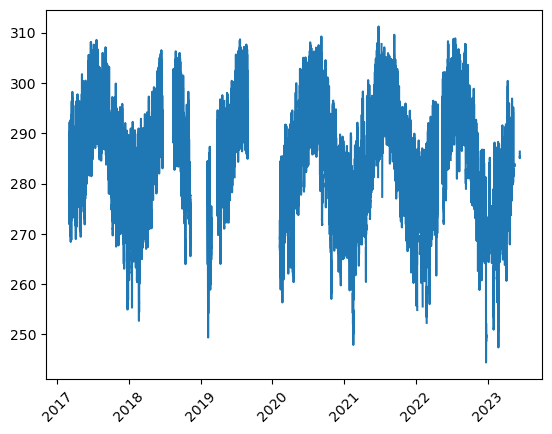

In [9]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_as_nc_path)

time_axis = ds.time.values
print(station_as_nc_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

import pandas as pd
df = pd.DataFrame(temperature_axis, index=time_axis, columns=['tas'])


start_date = None
end_date = None

# plot
if start_date is None or end_date is None:
    plt.plot(df.index, df.tas)
else:
    plt.plot(df[start_date:end_date].index, df[start_date:end_date].tas)

# rotate ticks
plt.xticks(rotation=45)

plt.show()

In [10]:
era5_getter = CreateMatchingEra5FileForStationData(station_name)
station_path = era5_getter.target_station_path
print(f"{station_name} coordinates: {era5_getter.station.get_lon_lat()}")
print(f"The data at {station_name} is inbetween {era5_getter.station.dataset.start_date} and {era5_getter.station.dataset.time_at_index(len(era5_getter.station.dataset.time)-1)}")
print("station cleared & processed file will be saved at: " + station_path)
print("era5 cleared & processed file will be saved at: " + era5_getter.target_era5_path)

Marshall coordinates: (-105.196, 39.9496)
The data at Marshall is inbetween 2017-03-01 05:00:00 and 2023-11-29 19:00:00
station cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc
era5 cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc


In [11]:
problemantic_files = era5_getter.extract_areas_from_era5_datasets()

choosing example era5 file from /work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/1hr/atmos/tas/r1i1p1
example_era5_file tas_1hr_reanalysis_era5_r1i1p1_20240201-20240229.nc
getting slices around: (-105.196, 39.9496)
era5 min / max lin: 902 910
era5 min / max lat: 458 466


Processing Files:   0%|          | 0/81 [00:00<?, ?file/s]

Processing Files: 100%|██████████| 81/81 [00:36<00:00,  2.21file/s]


Test lon / lat value differences

In [12]:
import netCDF4 as nc
import numpy as np
cropped_folder = era5_getter.target_temp_era5_folder
print(f"cropped_folder: {cropped_folder}")
last_lon = []
last_lat = []
for file in os.listdir(cropped_folder):
    ds = nc.Dataset(f"{cropped_folder}/{file.split('/')[-1]}")
    if len(last_lon):
        assert np.array_equal(last_lon, ds.variables['lon'][:]), f"{last_lon} != {ds.variables['lon'][:]} at {file}"
        assert np.array_equal(last_lat, ds.variables['lat'][:]), f"{last_lat} != {ds.variables['lat'][:]} at {file}"
    last_lon = ds.variables['lon'][:]
    last_lat = ds.variables['lat'][:]


cropped_folder: /work/bm1159/XCES/xces-work/k203179/data_sets_era5-crop_marshall


In [13]:
era5_getter.merge_era5_files()

'/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc'

# Leading and trailing timesteps

In [14]:
era5_original_path = era5_getter.target_era5_path.split("_leading_trailing")[0].split(".")[0] + ".nc"
era5_leading_trailing_path = era5_original_path.split(".")[0] + "_leading_trailing.nc"

leading_dataset_path = era5_original_path.split(".")[0] + "_leading.nc"
trailing_dataset_path = era5_original_path.split(".")[0] + "_trailing.nc"

 
import os

for path in [leading_dataset_path, trailing_dataset_path, era5_leading_trailing_path]:
    if os.path.isfile(path):
        os.system(f"rm {path}")

os.system(f"cp {era5_original_path} {leading_dataset_path}")
os.system(f"cp {era5_original_path} {trailing_dataset_path}")
    
# rename var
os.system(f"cdo chname,tas,leading_tas {leading_dataset_path} {leading_dataset_path}_tmp")
os.system(f"cdo chname,tas,trailing_tas {trailing_dataset_path} {trailing_dataset_path}_tmp")

os.system(f"mv {leading_dataset_path}_tmp {leading_dataset_path}")
os.system(f"mv {trailing_dataset_path}_tmp {trailing_dataset_path}")

print("rename_var: done")

# shift time
os.system(f"cdo setreftime,2000-01-01,01:00:00 -shifttime,-1hour {leading_dataset_path} {leading_dataset_path}_tmp")
os.system(f"cdo setreftime,2000-01-01,01:00:00 -shifttime,1hour  {trailing_dataset_path} {trailing_dataset_path}_tmp")

os.system(f"mv {leading_dataset_path}_tmp {leading_dataset_path}")
os.system(f"mv {trailing_dataset_path}_tmp {trailing_dataset_path}")

os.system(f"cdo delete,timestep=2,1 {leading_dataset_path} {leading_dataset_path}_tmp")
os.system(f"cdo delete,timestep=-2,-1 {trailing_dataset_path} {trailing_dataset_path}_tmp")
os.system(f"cdo delete,timestep=1,-1 {era5_original_path} {era5_original_path}_tmp")

os.system(f"mv {leading_dataset_path}_tmp {leading_dataset_path}")
os.system(f"mv {trailing_dataset_path}_tmp {trailing_dataset_path}")

print("shift_time: done")

# Define the command for selecting and merging the leading dataset
leading_command = f"cdo merge {leading_dataset_path} {era5_original_path}_tmp {era5_leading_trailing_path}"
# Execute the command
os.system(leading_command)
os.system(f"rm {era5_original_path}_tmp")

# Define the command for selecting and merging the trailing dataset
trailing_command = f"cdo merge {trailing_dataset_path} {era5_leading_trailing_path} {era5_leading_trailing_path}_tmp"
# Execute the command
os.system(trailing_command)

# rename _tmp to normal
os.system(f"mv {era5_leading_trailing_path}_tmp {era5_leading_trailing_path}")

os.system(f"rm {leading_dataset_path}")
os.system(f"rm {trailing_dataset_path}")

print("merge_vars done")

rename_var: done
shift_time: done
merge_vars done


In [15]:
era5_getter.target_era5_path = era5_leading_trailing_path
print(f"era5_getter.target_era5_path: {era5_getter.target_era5_path}")

era5_getter.target_era5_path: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall_leading_trailing.nc


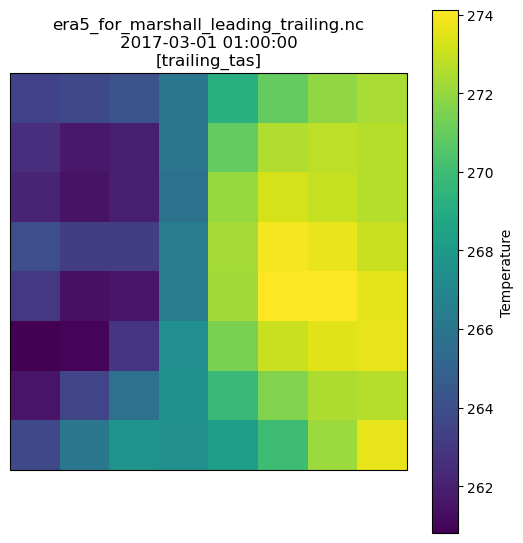

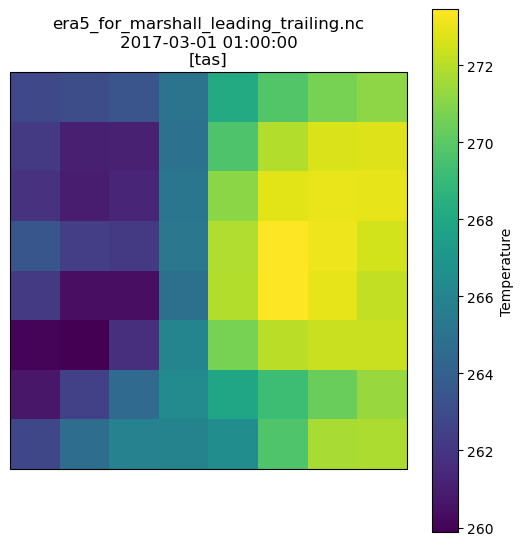

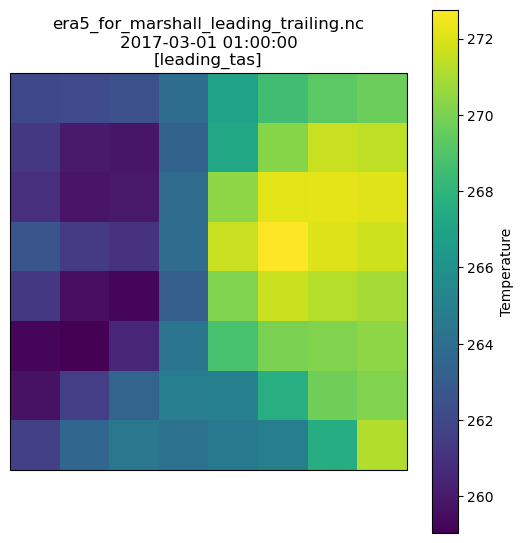

In [16]:
from utils import DataSet, DatasetPlotter
era5_merged = DataSet(era5_getter.target_era5_path)

plotter = DatasetPlotter(era5_merged)
plotter.time_index_list = [0]
plotter.plot(["trailing_tas", "tas", "leading_tas"])

In [17]:
era5_getter.transform_era5_to_match_station_time_dimension()

station data goes from 2017-03-01 05:00:00 to 2023-11-29 19:00:00
era5 data goes from 2017-03-01 01:00:00 to 2023-11-30 22:00:00
cropping time axis to intersection of station and era5 dataset
start/enddate (utc): 2017-03-01 05:00:00 / 2023-11-29 19:00:00


Checking tas: 100%|██████████| 59150/59150 [00:19<00:00, 2968.85it/s]


Found 15515 invalid values in station dataset
Cropped time axis to intersection of station and era5 dataset
Deleting timesteps without measurements from station dataset


100%|██████████| 15515/15515 [00:19<00:00, 806.48it/s]


Deleted 15515 timesteps from /home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/marshall.nc_temp dataset because of invalid values
Deleting time steps without measurements from era5 dataset


  0%|          | 0/15515 [00:00<?, ?it/s]cdo    cat: Open failed on >/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_the_gaps_marshall.nc_t<
            No such file or directory
rm: cannot remove '/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_the_gaps_marshall.nc_t': No such file or directory
100%|██████████| 15515/15515 [00:47<00:00, 324.92it/s]

Deleted 15515 timesteps from /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall_leading_trailing.nc_temp dataset because of invalid values


('/work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc',
 '/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall_leading_trailing.nc')

/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall_leading_trailing.nc has  43636  values


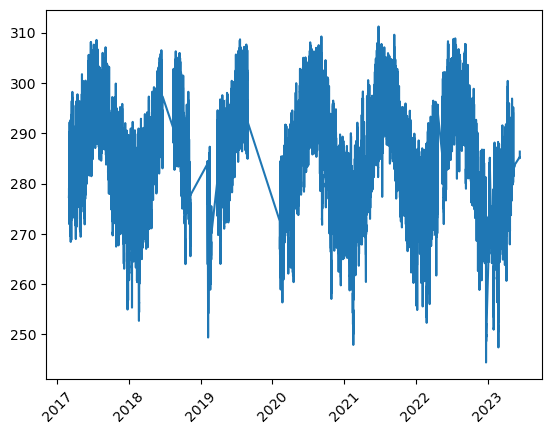

In [18]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_path)
time_axis = ds.time.values
print(era5_getter.target_era5_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)

# rotate x axis labels
plt.xticks(rotation=45)

plt.show()

In [19]:
do_time_context = False
if do_time_context:
    time_context_adder = TimeAndDateContext()
    time_context_adder.generate_time_context_variables_in_dataset(era5_getter.target_era5_path)


In [20]:
# convert F64 to F32 using cdo -b F32 copy input.nc output.nc
import subprocess
subprocess.run(["cdo", "-b", "F32", "copy", era5_getter.target_era5_path, era5_getter.target_era5_path + "_f32"])

os.system(f"mv {era5_getter.target_era5_path + '_f32'} {era5_getter.target_era5_path}")

0

In [21]:
era5_getter.target_era5_path = era5_getter.target_era5_path.split("_leading_trailing")[0].split(".")[0] + "_leading_trailing.nc"
print(f"era5_getter.target_era5_path: {era5_getter.target_era5_path}")
trainings_file_pair_creator = TrainingsFilePair(station_path, era5_getter.target_era5_path, test_year=test_year)
trainings_file_pair_creator.prepare_trainings_files()

era5_getter.target_era5_path: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall_leading_trailing.nc


preparing /work/bm1159/XCES/xces-work/k203179/data/val/marshall.nc: 100%|██████████| 8408/8408 [00:02<00:00, 2936.50it/s]
preparing /work/bm1159/XCES/xces-work/k203179/data/train/marshall.nc: 100%|██████████| 35228/35228 [00:12<00:00, 2869.50it/s]


/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_the_gaps_marshall.nc
Splitting leading_tas in /work/bm1159/XCES/xces-work/k203179/data/test
Splitting trailing_tas in /work/bm1159/XCES/xces-work/k203179/data/test
Splitting leading_tas in /work/bm1159/XCES/xces-work/k203179/data/train
Splitting trailing_tas in /work/bm1159/XCES/xces-work/k203179/data/train
Splitting leading_tas in /work/bm1159/XCES/xces-work/k203179/data/val
Splitting trailing_tas in /work/bm1159/XCES/xces-work/k203179/data/val
Splitting leading_tas in /work/bm1159/XCES/xces-work/k203179/data/test
Splitting trailing_tas in /work/bm1159/XCES/xces-work/k203179/data/test


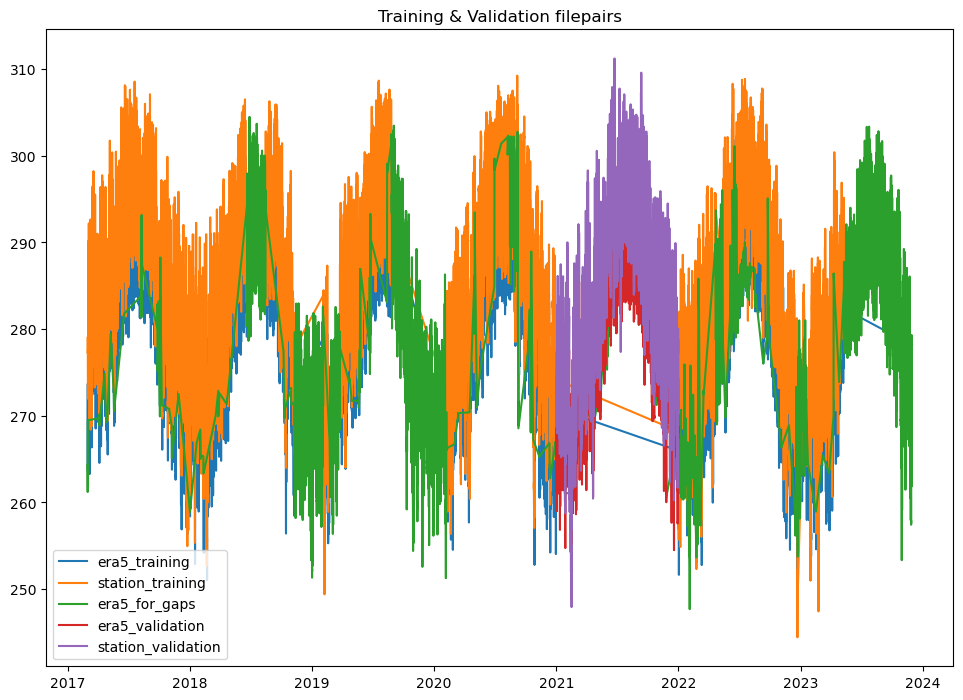

In [22]:
import xarray as xr

data_folder = trainings_file_pair_creator.data_folder
train_folder = f"{data_folder}/train"
train_era_file = f"{train_folder}/era5_for_{station_name.lower()}_leading_trailing.nc"
era_gaps_file = era5_getter.target_era5_for_the_gaps_path
train_station_file = f"{train_folder}/expected_{station_name.lower()}.nc"
ds_era = xr.open_dataset(train_era_file)
ds_era_for_gaps = xr.open_dataset(era_gaps_file)
ds_station = xr.open_dataset(train_station_file)

# plot temperature of the station with gaps where no data is available over the years
import matplotlib.pyplot as plt

plt.plot(ds_era.time.values, ds_era.tas.values.mean(axis=(1, 2)), label="era5_training")
plt.plot(ds_station.time.values, ds_station.tas.values.mean(axis=(1, 2)), label="station_training")
plt.title("Training & Validation filepairs")

val_folder = f"{data_folder}/val"
val_era_file = f"{val_folder}/era5_for_{station_name.lower()}_leading_trailing.nc"
val_station_file = f"{val_folder}/expected_{station_name.lower()}.nc"
ds_era = xr.open_dataset(val_era_file)
ds_station = xr.open_dataset(val_station_file)

# plot temperature of the station with gaps where no data is available over the years
plt.plot(ds_era_for_gaps.time.values, ds_era_for_gaps.tas.values.mean(axis=(1, 2)), label="era5_for_gaps")
plt.plot(ds_era.time.values, ds_era.tas.values.mean(axis=(1, 2)), label="era5_validation")
plt.plot(ds_station.time.values, ds_station.tas.values.mean(axis=(1, 2)), label="station_validation")

# figsize to A4 landscape
plt.gcf().set_size_inches(11.7, 8.27)

plt.legend()
plt.show()


In [23]:
if do_time_context:
    from utils import DataSet, DatasetPlotter
    test_expected_set = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc")
    plotter = DatasetPlotter(test_expected_set)
    plotter.time_index_list = [x + 222 for x in range(0, 24)]
    plotter.vmin = -1
    plotter.vmax = 1
    plotter.plot(var="intra_day")